# Tune hyperparamters of all the Xgboost models to improve the RMSE.

-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [3]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

In [4]:
import os
os.getcwd()

'C:\\Users\\ankan\\Desktop\\New folder (2)'

__Reading The Sampled data__

In [7]:
reg_train = pd.read_csv('sampled_train_assignment.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,39297,33,3.575734,5.0,5.0,2.0,4.0,5.0,5.0,5.0,5.0,5.0,2.0,3.269565,4.143646,5
1,53406,33,3.575734,4.0,5.0,4.0,5.0,4.0,2.0,5.0,5.0,3.0,3.0,3.370370,4.143646,4
2,67390,33,3.575734,5.0,1.0,5.0,4.0,5.0,4.0,4.0,3.0,4.0,2.0,3.833333,4.143646,4
3,99540,33,3.575734,5.0,5.0,4.0,5.0,5.0,3.0,5.0,4.0,4.0,3.0,3.555556,4.143646,3
4,99865,33,3.575734,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,3.714286,4.143646,5


In [6]:
reg_test_df = pd.read_csv('sampled_test_assignment.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,5
1,941866,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,4
2,1737912,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3
3,1849204,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

In [8]:
from surprise import Reader, Dataset

<h3>  Suprise BaselineModel </h3>
    

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 


__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [9]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader = reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [10]:
import xgboost as xgb

In [11]:
print(trainset)

In [12]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

In [13]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [14]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

In [20]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

In [15]:
from numpy import loadtxt
from matplotlib import pyplot

In [16]:
# prepare Train data
start = datetime.now()

x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results


print("",datetime.now() - start)  

Training the model..
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[17:09:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

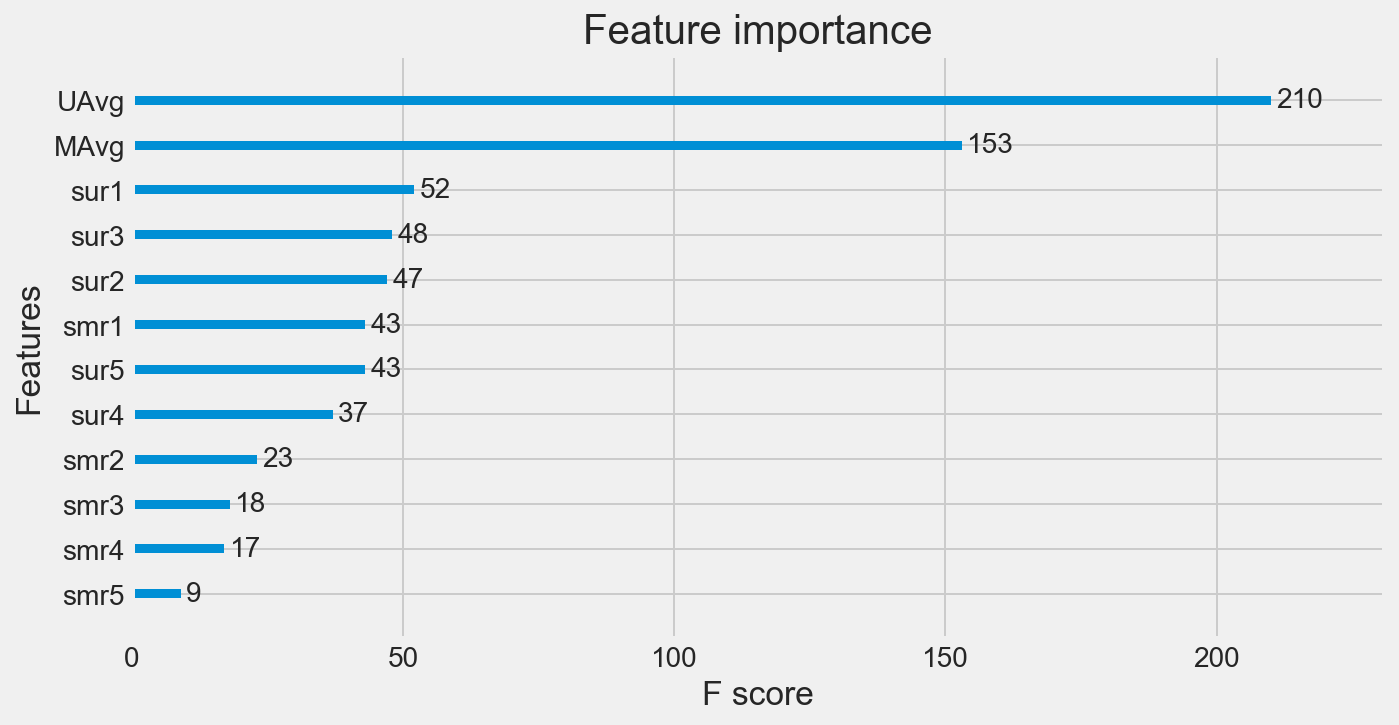

In [17]:
xgb.plot_importance(first_xgb)
plt.show()

In [18]:
from datetime import datetime
from  tqdm import tqdm
from surprise import Reader, Dataset
from surprise import BaselineOnly 
from surprise import accuracy
from surprise import KNNBaseline
from surprise import SVD,SVDpp
from surprise.model_selection import GridSearchCV

In [18]:
start = datetime.now()
bsl_options = {'method': 'sgd','learning_rate':0.001}
print("Estimating biases using sgd with learning rate 0.001...")
for i in tqdm(range(10,200,10)):
    bsl_options['n_epochs']=i
    algo_sgd = BaselineOnly(bsl_options=bsl_options,verbose=False)
    algo_sgd.fit(trainset)
    print('-'*75)
    print("Accuracy for n_epochs :",i)
    predictions = algo_sgd.test(trainset.build_testset())
    print("RMSE on Train data:",accuracy.rmse(predictions))

    predictions = algo_sgd.test(testset)
    print("RMSE on Test data:",accuracy.rmse(predictions))


print("Time taken:",datetime.now()-start)

Estimating biases using sgd with learning rate 0.001...


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

---------------------------------------------------------------------------
Accuracy for n_epochs : 10
RMSE: 0.9577
RMSE on Train data: 0.9576677229767121
RMSE: 1.0728
RMSE on Test data: 1.072769466749761


  5%|████▎                                                                              | 1/19 [00:01<00:35,  1.99s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 20
RMSE: 0.9350
RMSE on Train data: 0.9350205122246975
RMSE: 1.0724
RMSE on Test data: 1.0723643328580403


 11%|████████▋                                                                          | 2/19 [00:04<00:35,  2.08s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 30
RMSE: 0.9224
RMSE on Train data: 0.9224455636144915
RMSE: 1.0722
RMSE on Test data: 1.0721621286872336


 16%|█████████████                                                                      | 3/19 [00:06<00:36,  2.27s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 40
RMSE: 0.9142
RMSE on Train data: 0.9142390824492429
RMSE: 1.0720
RMSE on Test data: 1.0720382021319843


 21%|█████████████████▍                                                                 | 4/19 [00:10<00:37,  2.53s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 50
RMSE: 0.9084
RMSE on Train data: 0.9083843844357417
RMSE: 1.0720
RMSE on Test data: 1.0719569145021046


 26%|█████████████████████▊                                                             | 5/19 [00:13<00:39,  2.80s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 60
RMSE: 0.9040
RMSE on Train data: 0.9039600779936857
RMSE: 1.0719
RMSE on Test data: 1.0719022438761272


 32%|██████████████████████████▏                                                        | 6/19 [00:17<00:40,  3.13s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 70
RMSE: 0.9005
RMSE on Train data: 0.9004786746474502
RMSE: 1.0719
RMSE on Test data: 1.0718654461129775


 37%|██████████████████████████████▌                                                    | 7/19 [00:21<00:42,  3.51s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 80
RMSE: 0.8977
RMSE on Train data: 0.8976569355971216
RMSE: 1.0718
RMSE on Test data: 1.0718411841716273


 42%|██████████████████████████████████▉                                                | 8/19 [00:26<00:42,  3.90s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 90
RMSE: 0.8953
RMSE on Train data: 0.8953151527747121
RMSE: 1.0718
RMSE on Test data: 1.0718259599667341


 47%|███████████████████████████████████████▎                                           | 9/19 [00:31<00:42,  4.27s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 100
RMSE: 0.8933
RMSE on Train data: 0.8933356688553619
RMSE: 1.0718
RMSE on Test data: 1.0718173683836074


 53%|███████████████████████████████████████████▏                                      | 10/19 [00:37<00:41,  4.65s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 110
RMSE: 0.8916
RMSE on Train data: 0.8916376643893758
RMSE: 1.0718
RMSE on Test data: 1.0718136995197474


 58%|███████████████████████████████████████████████▍                                  | 11/19 [00:43<00:40,  5.07s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 120
RMSE: 0.8902
RMSE on Train data: 0.8901626849352082
RMSE: 1.0718
RMSE on Test data: 1.071813708144235


 63%|███████████████████████████████████████████████████▊                              | 12/19 [00:49<00:38,  5.43s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 130
RMSE: 0.8889
RMSE on Train data: 0.8888683496050056
RMSE: 1.0718
RMSE on Test data: 1.0718164713332776


 68%|████████████████████████████████████████████████████████                          | 13/19 [00:56<00:35,  5.87s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 140
RMSE: 0.8877
RMSE on Train data: 0.8877219492417691
RMSE: 1.0718
RMSE on Test data: 1.0718212960853415


 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [01:03<00:31,  6.30s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 150
RMSE: 0.8867
RMSE on Train data: 0.8866994516224468
RMSE: 1.0718
RMSE on Test data: 1.0718276569693046


 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [01:11<00:27,  6.76s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 160
RMSE: 0.8858
RMSE on Train data: 0.8857812370575939
RMSE: 1.0718
RMSE on Test data: 1.0718351527159757


 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [01:19<00:21,  7.13s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 170
RMSE: 0.8850
RMSE on Train data: 0.8849519028126426
RMSE: 1.0718
RMSE on Test data: 1.0718434752494874


 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [01:28<00:15,  7.55s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 180
RMSE: 0.8842
RMSE on Train data: 0.8841991179818213
RMSE: 1.0719
RMSE on Test data: 1.0718523871629422


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [01:37<00:08,  8.11s/it]

---------------------------------------------------------------------------
Accuracy for n_epochs : 190
RMSE: 0.8835
RMSE on Train data: 0.8835127260183862
RMSE: 1.0719
RMSE on Test data: 1.0718617050822694


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  8.62s/it]


Time taken: 0:01:47.422308


In [25]:
from surprise import BaselineOnly 

In [21]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001,
                'n_epochs' : 110}
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['Baseline Train'] = bsl_train_results 
models_evaluation_test['Baseline Test'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:05.387918 

Evaluating the model with train data..
time taken : 0:00:01.475841
---------------
Train Data
---------------
RMSE : 0.8916376643893758

MAPE : 27.494794025369192

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.170141
---------------
Test Data
---------------
RMSE : 1.0718136995197474

MAPE : 34.9203417260073

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:07.049522


In [22]:
# add our baseline_predicted value as our feature..
reg_train['Baseline'] = models_evaluation_train['Baseline Train']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,Baseline
0,39297,33,3.575734,5.0,5.0,2.0,4.0,5.0,5.0,5.0,5.0,5.0,2.0,3.269565,4.143646,5,3.894373
1,53406,33,3.575734,4.0,5.0,4.0,5.0,4.0,2.0,5.0,5.0,3.0,3.0,3.370370,4.143646,4,2.970140


In [23]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['Baseline']  = models_evaluation_test['Baseline Test']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,Baseline
0,808635,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,5,3.575734
1,941866,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,4,3.575734


In [24]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs= -1, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_baseline'] = train_results
models_evaluation_test['xgb_baseline'] = test_results




Training the model..
[17:10:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:10:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:10:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

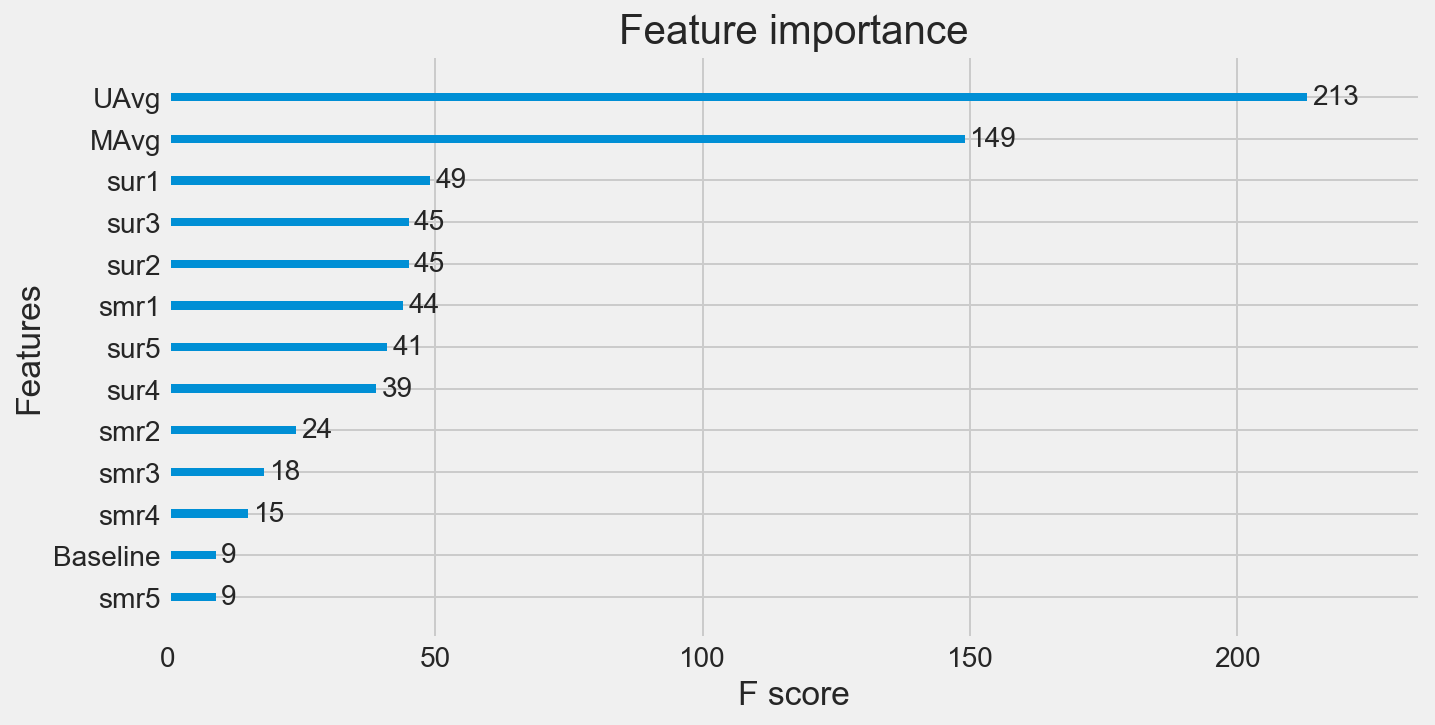

In [25]:
xgb.plot_importance(xgb_bsl)
plt.show()

In [26]:
from surprise.model_selection import GridSearchCV as gcv
#https://github.com/NicolasHug/Surprise/issues/190

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 
    
- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 

- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 
    
 - __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
    
    
- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

In [32]:

param_grid  = {'sim_options':
               {'name': ["pearson_baseline"], 
                "user_based": [True], "min_support": [2], 
                "shrinkage": [60, 80, 100, 140]},
                'k': [25,50,75,100],
                'min_k': [2,4,6,8,10]}
gcv = gcv(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gcv.fit(train_data)




# best RMSE score
print(gcv.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gcv.best_params['rmse'])




Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [27]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 140,
               'min_support': 2,
               'k' : 75,
               'min_k' : 10
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
baseline_options = {'method': 'als'} 

#knn_baseline_u = KNNBaseline(k=40, sim_options = sim_options, baseline_options = baseline_options)
knn_baseline_a=KNNBaseline(sim_options=sim_options,baseline_options=baseline_options)
knn_baseline_a_train_results, knn_baseline_a_test_results = run_surprise(knn_baseline_a, trainset, testset, verbose=True)



Training the model...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:01:57.132869 

Evaluating the model with train data..
time taken : 0:04:54.141851
---------------
Train Data
---------------
RMSE : 0.31260190821020073

MAPE : 8.613695134139803

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.089758
---------------
Test Data
---------------
RMSE : 1.0721489211175521

MAPE : 34.95162103347572

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:06:51.486700


In [28]:
# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_baseline_user_als'] = knn_baseline_a_train_results 
models_evaluation_test['knn_baseline_user_als'] = knn_baseline_a_test_results 
models_evaluation_train['knn_baseline_movie_als'] = knn_baseline_a_train_results
models_evaluation_test['knn_baseline_movie_als'] = knn_baseline_a_test_results


In [29]:
##add the predicted values from both knns to this dataframe
reg_train['knn_baseline_user_als'] = models_evaluation_train['knn_baseline_user_als']['predictions']
reg_train['knn_baseline_movie_als'] = models_evaluation_train['knn_baseline_movie_als']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,Baseline,knn_baseline_user_als,knn_baseline_movie_als
0,39297,33,3.575734,5.0,5.0,2.0,4.0,5.0,5.0,5.0,5.0,5.0,2.0,3.269565,4.143646,5,3.894373,4.405804,4.405804
1,53406,33,3.575734,4.0,5.0,4.0,5.0,4.0,2.0,5.0,5.0,3.0,3.0,3.370370,4.143646,4,2.970140,2.758903,2.758903


In [30]:
reg_test_df['knn_baseline_user_als'] = models_evaluation_test['knn_baseline_user_als']['predictions']
reg_test_df['knn_baseline_movie_als'] = models_evaluation_test['knn_baseline_movie_als']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,Baseline,knn_baseline_user_als,knn_baseline_movie_als
0,808635,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,5,3.575734,3.575734,3.575734
1,941866,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,4,3.575734,3.575734,3.575734


In [31]:
reg_train.to_csv("reg_train.csv")
reg_test_df.to_csv("reg_test_df.csv")

In [25]:
start=datetime.now()

sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
baseline_options = {'method': 'sgd'} 
#algo =KNNBaseline(sim_options =sim_options ,baseline_options=baseline_options)
#param_grid = {'k': [25,50,75,100],'min_k':[2,4,6,8,10]}
k_range,min_k_range=[25,50,75,100],[2,4,6,8,10]
RMSE={}
for k in tqdm(k_range):
    for min_k in tqdm(min_k_range):
        knn_baseline_u=KNNBaseline(k=k,min_k=min_k,sim_options=sim_options,baseline_options=baseline_options)
        #knn_baseline_u= gcv(algo,param_grid,n_jobs = -1)
        ##https://github.com/NicolasHug/Surprise/issues/190 
        #I did not understand how to solve the issue!!!!!!!!!!!!!
        knn_baseline_u.fit(trainset)
        
        print('='*100)
        print("For k={} and min_k={} :".format(k,min_k))
        predictions = knn_baseline_u.test(trainset.build_testset())
        print("RMSE on Train data:",accuracy.rmse(predictions))

        predictions = knn_baseline_u.test(testset)
        print("RMSE on Test data:",accuracy.rmse(predictions))
        RMSE[(k,min_k)]=accuracy.rmse(predictions)


print("Time Taken : ",datetime.now()-start)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=25 and min_k=2 :
RMSE: 0.3162
RMSE on Train data: 0.31624467056686356
RMSE: 1.0719
RMSE on Test data: 1.071944801315549
RMSE: 1.0719



 20%|████████████████▌                                                                  | 1/5 [04:47<19:09, 287.33s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=25 and min_k=4 :
RMSE: 0.3255
RMSE on Train data: 0.3254528025675684
RMSE: 1.0719
RMSE on Test data: 1.071944801315549
RMSE: 1.0719



 40%|█████████████████████████████████▏                                                 | 2/5 [09:41<14:28, 289.44s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=25 and min_k=6 :
RMSE: 0.3338
RMSE on Train data: 0.33384465490071297
RMSE: 1.0719
RMSE on Test data: 1.071944801315549
RMSE: 1.0719



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [14:35<09:41, 290.76s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=25 and min_k=8 :
RMSE: 0.3404
RMSE on Train data: 0.3404080062530812
RMSE: 1.0719
RMSE on Test data: 1.0718886929878912
RMSE: 1.0719



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [19:36<04:53, 293.81s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=25 and min_k=10 :
RMSE: 0.3450
RMSE on Train data: 0.3449948274033518
RMSE: 1.0719
RMSE on Test data: 1.0718886929878912
RMSE: 1.0719



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=50 and min_k=2 :
RMSE: 0.3715
RMSE on Train data: 0.3714687122252297
RMSE: 1.0720
RMSE on Test data: 1.0719554015624815
RMSE: 1.0720



 20%|████████████████▌                                                                  | 1/5 [05:11<20:44, 311.18s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=50 and min_k=4 :
RMSE: 0.3793
RMSE on Train data: 0.3793386866632656
RMSE: 1.0720
RMSE on Test data: 1.0719554015624815
RMSE: 1.0720



 40%|█████████████████████████████████▏                                                 | 2/5 [10:07<15:20, 306.83s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=50 and min_k=6 :
RMSE: 0.3866
RMSE on Train data: 0.38656249961177375
RMSE: 1.0720
RMSE on Test data: 1.0719554015624815
RMSE: 1.0720



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [15:21<10:17, 308.96s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=50 and min_k=8 :
RMSE: 0.3922
RMSE on Train data: 0.39224472363758345
RMSE: 1.0719
RMSE on Test data: 1.0718992937896912
RMSE: 1.0719



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [20:23<05:06, 306.77s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=50 and min_k=10 :
RMSE: 0.3962
RMSE on Train data: 0.3962319313677218
RMSE: 1.0719
RMSE on Test data: 1.0718992937896912
RMSE: 1.0719



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=75 and min_k=2 :
RMSE: 0.3991
RMSE on Train data: 0.3991001659669154
RMSE: 1.0719
RMSE on Test data: 1.0719421585229487
RMSE: 1.0719



 20%|████████████████▌                                                                  | 1/5 [05:09<20:37, 309.39s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=75 and min_k=4 :
RMSE: 0.4064
RMSE on Train data: 0.4064354530696849
RMSE: 1.0719
RMSE on Test data: 1.0719421585229487
RMSE: 1.0719



 40%|█████████████████████████████████▏                                                 | 2/5 [10:35<15:43, 314.35s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=75 and min_k=6 :
RMSE: 0.4132
RMSE on Train data: 0.41318579890728513
RMSE: 1.0719
RMSE on Test data: 1.0719421585229487
RMSE: 1.0719



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [16:10<10:41, 320.52s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=75 and min_k=8 :
RMSE: 0.4185
RMSE on Train data: 0.4185067042880832
RMSE: 1.0719
RMSE on Test data: 1.0718860500569527
RMSE: 1.0719



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [21:42<05:23, 323.96s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=75 and min_k=10 :
RMSE: 0.4222
RMSE on Train data: 0.4222459967222233
RMSE: 1.0719
RMSE on Test data: 1.0718860500569527
RMSE: 1.0719



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=100 and min_k=2 :
RMSE: 0.4166
RMSE on Train data: 0.4166384231108795
RMSE: 1.0719
RMSE on Test data: 1.0719422584399805
RMSE: 1.0719



 20%|████████████████▌                                                                  | 1/5 [05:46<23:04, 346.14s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=100 and min_k=4 :
RMSE: 0.4237
RMSE on Train data: 0.4236701672875504
RMSE: 1.0719
RMSE on Test data: 1.0719422584399805
RMSE: 1.0719



 40%|█████████████████████████████████▏                                                 | 2/5 [11:16<17:04, 341.47s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=100 and min_k=6 :
RMSE: 0.4302
RMSE on Train data: 0.4301501337395495
RMSE: 1.0719
RMSE on Test data: 1.0719422584399805
RMSE: 1.0719



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [17:02<11:25, 342.76s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=100 and min_k=8 :
RMSE: 0.4353
RMSE on Train data: 0.43526370704616996
RMSE: 1.0719
RMSE on Test data: 1.0718861499792147
RMSE: 1.0719



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [22:49<05:44, 344.13s/it]

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
For k=100 and min_k=10 :
RMSE: 0.4389
RMSE on Train data: 0.4388602452779754
RMSE: 1.0719
RMSE on Test data: 1.0718861499792147
RMSE: 1.0719



100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:45:36<00:00, 1584.54s/it]


Time Taken :  1:45:36.363293


In [32]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
baseline_options = {'method': 'sgd'} 

#knn_baseline_u = KNNBaseline(k=40, sim_options = sim_options, baseline_options = baseline_options)
knn_baseline_u=KNNBaseline(k=100,min_k=19,sim_options=sim_options,baseline_options=baseline_options)
knn_baseline_u_train_results, knn_baseline_u_test_results = run_surprise(knn_baseline_u, trainset, testset, verbose=True)




Training the model...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:02:40.531247 

Evaluating the model with train data..
time taken : 0:05:51.345762
---------------
Train Data
---------------
RMSE : 0.4564125903210284

MAPE : 13.00085115096095

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.089909
---------------
Test Data
---------------
RMSE : 1.0720287214545254

MAPE : 34.94689485018746

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:08:31.996859


In [33]:
# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_baseline_user'] = knn_baseline_u_train_results 
models_evaluation_test['knn_baseline_user'] = knn_baseline_u_test_results 
models_evaluation_train['knn_baseline_movie'] = knn_baseline_u_train_results
models_evaluation_test['knn_baseline_movie'] = knn_baseline_u_test_results


In [34]:
##add the predicted values from both knns to this dataframe
reg_train['knn_baseline_user'] = models_evaluation_train['knn_baseline_user']['predictions']
reg_train['knn_baseline_movie'] = models_evaluation_train['knn_baseline_movie']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,Baseline,knn_baseline_user_als,knn_baseline_movie_als,knn_baseline_user,knn_baseline_movie
0,39297,33,3.575734,5.0,5.0,2.0,4.0,5.0,5.0,5.0,...,5.0,2.0,3.269565,4.143646,5,3.894373,4.405804,4.405804,4.32357,4.32357
1,53406,33,3.575734,4.0,5.0,4.0,5.0,4.0,2.0,5.0,...,3.0,3.0,3.370370,4.143646,4,2.970140,2.758903,2.758903,2.88604,2.88604


In [35]:
reg_test_df['knn_baseline_user'] = models_evaluation_test['knn_baseline_user']['predictions']
reg_test_df['knn_baseline_movie'] = models_evaluation_test['knn_baseline_movie']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,Baseline,knn_baseline_user_als,knn_baseline_movie_als,knn_baseline_user,knn_baseline_movie
0,808635,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,...,3.575734,3.575734,3.575734,3.575734,5,3.575734,3.575734,3.575734,3.575734,3.575734
1,941866,71,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,3.575734,...,3.575734,3.575734,3.575734,3.575734,4,3.575734,3.575734,3.575734,3.575734,3.575734


In [36]:
reg_train.to_csv("reg_train.csv")
reg_test_df.to_csv("reg_test_df.csv")

In [37]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_baseline = xgb.XGBRegressor(n_jobs= -1, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_baseline, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_baseline'] = train_results
models_evaluation_test['xgb_knn_baseline'] = test_results




Training the model..
Done. Time taken : 0:00:12.425583

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0751166362484994
MAPE :  34.40845763348976


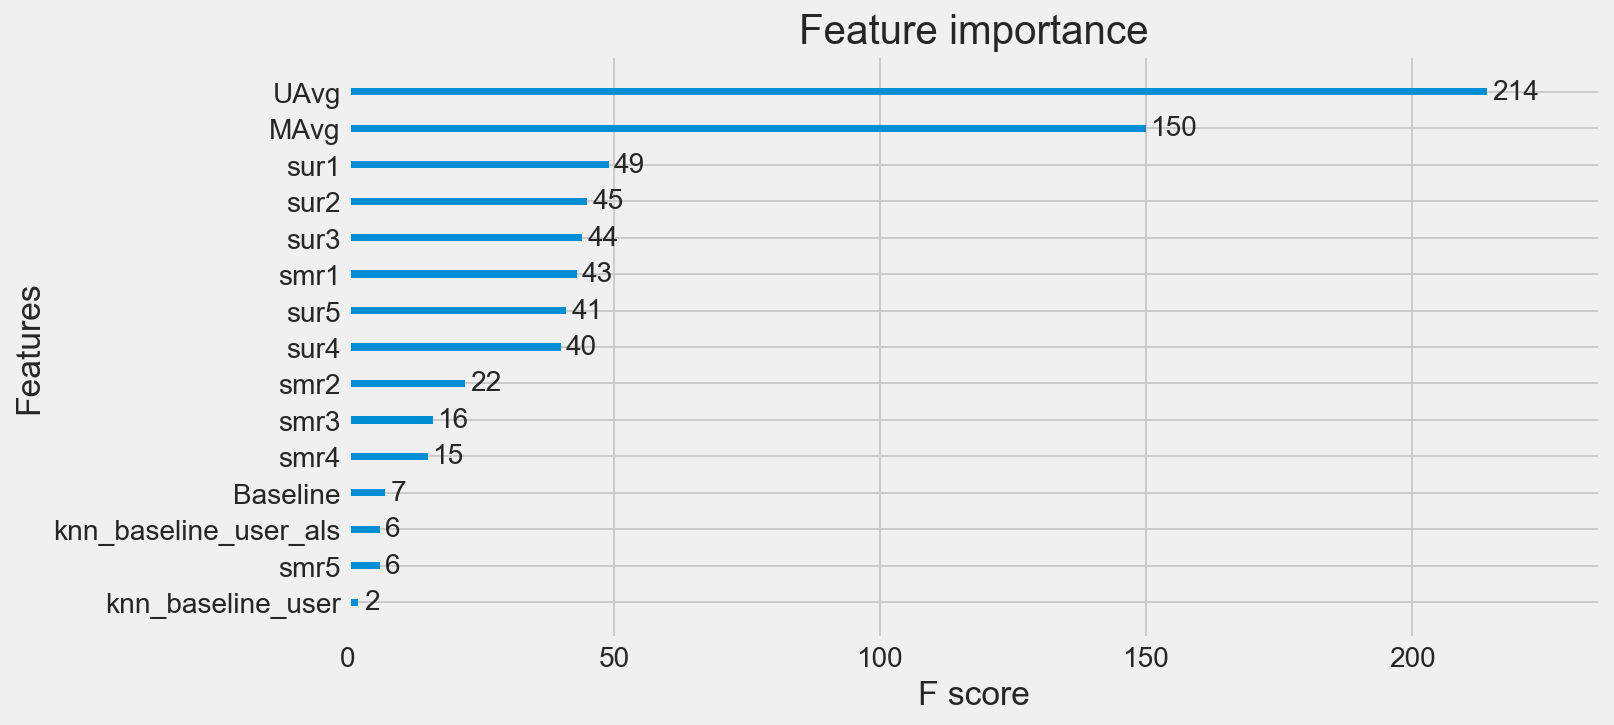

In [38]:
xgb.plot_importance(xgb_knn_baseline)
plt.show()

__SVD: (http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD )__



- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        
- A BASIC MATRIX FACTORIZATION MODEL in  https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [69]:
start=datetime.now()
param_grid = {'n_epochs': [15, 20, 25, 30, 35, 40, 45, 50],
              'n_factors': [100, 200, 300],
              'lr_all': [0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.02,0.01,0.05,0.1, 0.4, 0.6]}
svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1)

svd.fit(train_data)

print("RMSE score", svd.best_score['rmse'])


print("Best Parameters", svd.best_params['rmse'])
print("Time Taken:",datetime.now()-start)

RMSE score 0.9334129800903389
Best Parameters {'n_epochs': 50, 'n_factors': 300, 'lr_all': 0.005, 'reg_all': 0.1}
Time Taken: 5:56:10.171335


In [39]:
# initiallize the model
svd = SVD(n_factors=300,n_epochs = 50, lr_all = 0.0005, reg_all = 0.1, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processi

In [40]:
reg_train['svd'] = svd_train_results['predictions']
reg_test_df['svd'] = svd_test_results['predictions']

In [41]:
reg_train.to_csv("reg_train.csv")
reg_test_df.to_csv("reg_test_df.csv")

__SVD++: (- ----->  2.5 Implicit Feedback in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)__

- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 
    
    
 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  


- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [50]:
from surprise import SVDpp

In [51]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:03:29.943381 

Evaluating the model with train data..
time taken : 0:00:08.875565
---------------
Train Data
---------------
RMSE : 0.6055768503411023

MAPE : 17.571545001485987

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.100149
---------------
Test Data
---------------
RMSE : 1.0718983014554764

MAPE : 34.93041229462388

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:03:38.948768


In [52]:
reg_train['svdpp'] = svdpp_train_results['predictions']
reg_test_df['svdpp'] = svdpp_test_results['predictions']

In [53]:
reg_train.to_csv("reg_train.csv")
reg_test_df.to_csv("reg_test_df.csv")

In [54]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs= -1, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results




Training the model..
Done. Time taken : 0:00:11.654629

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0749603389312379
MAPE :  34.42296359792526


In [55]:
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,UAvg,MAvg,rating,Baseline,knn_baseline_user_als,knn_baseline_movie_als,knn_baseline_user,knn_baseline_movie,svd,svdpp
0,39297,33,3.575734,5.0,5.0,2.0,4.0,5.0,5.0,5.0,...,3.269565,4.143646,5,3.894373,4.405804,4.405804,4.323570,4.323570,3.962349,3.898257
1,53406,33,3.575734,4.0,5.0,4.0,5.0,4.0,2.0,5.0,...,3.370370,4.143646,4,2.970140,2.758903,2.758903,2.886040,2.886040,2.946627,2.586045
2,67390,33,3.575734,5.0,1.0,5.0,4.0,5.0,4.0,4.0,...,3.833333,4.143646,4,3.301243,3.880904,3.880904,3.712182,3.712182,3.313549,3.111178
3,99540,33,3.575734,5.0,5.0,4.0,5.0,5.0,3.0,5.0,...,3.555556,4.143646,3,3.534162,3.251597,3.251597,3.375640,3.375640,3.578717,3.454828
4,99865,33,3.575734,5.0,4.0,5.0,4.0,5.0,4.0,5.0,...,3.714286,4.143646,5,3.055001,2.951288,2.951288,2.956873,2.956873,3.161478,2.866846


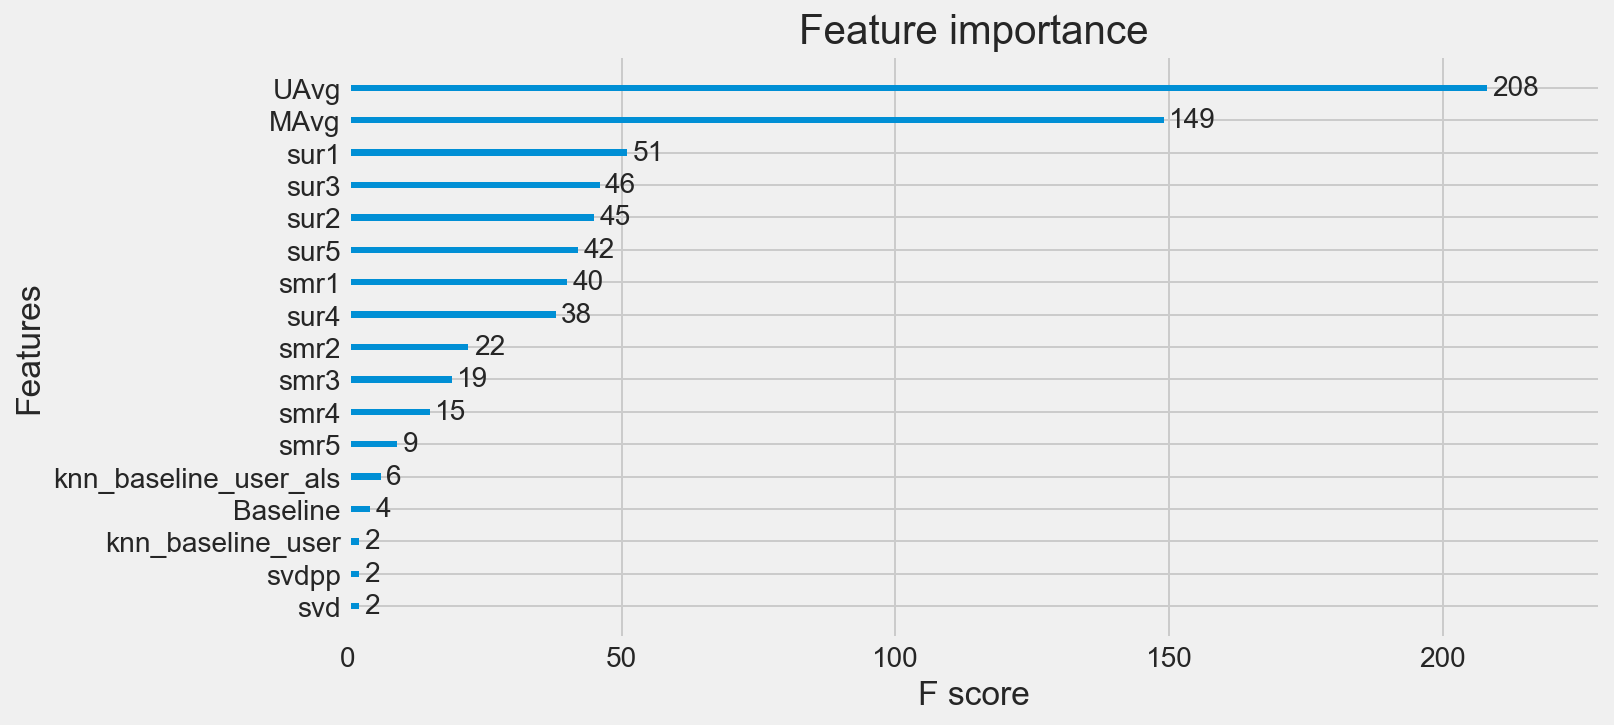

In [56]:
xgb.plot_importance(xgb_final)
plt.show()

<h1>Summary</h1>
<p>Here is a Comparison of our models.</p>


<table style="width:100%">
  <tr>
      <th>UAvg</th>
    <th>Mavg</th>
    <th>Sur1</th>
    <th>Sur2</th>
      <th>Sur3</th>
      <th>Sur4</th>
      <th>Sur5</th>
      <th>smr1</th>
      <th>smr2</th>
      <th>smr3</th>
      <th>smr4</th>
      <th>smr5</th>
      <th>Baseline</th>
   <th>SVD</th>
    <th>SVD++</th>
    <th>KNN baseline als</th>
     <th>KNN Baseline user</th>
      
      
      
  </tr>
  <tr>
    <td>208</td>
    <td>149</td>
    <td>51</td>
    <td>45</td>
       <td>46</td>
        <td>38</td>
    <td>42</td>
    <td>40</td>
    <td>22</td>
       <td>19</td>
        <td>15</td>
    <td>9</td>
    <td>4</td>
    <td>2</td>
       <td>2</td>
        <td>6</td>
       <td>2</td>
   
  </tr>
   
</table> 

Training the model..
Done. Time taken : 0:00:04.677355

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0750582949994654
MAPE :  35.16563995447293


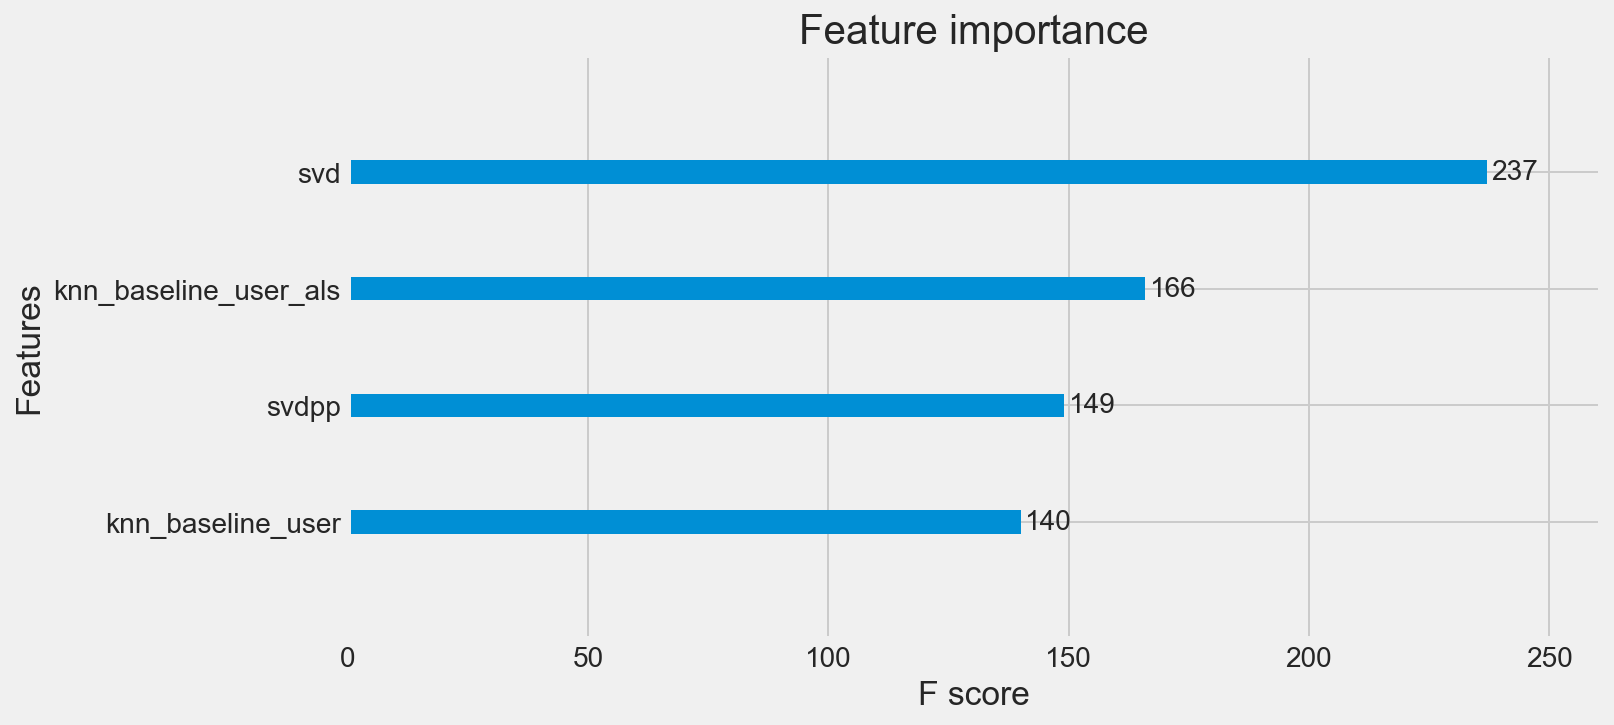

In [57]:
# prepare train data
x_train = reg_train[['knn_baseline_user_als', 'knn_baseline_user', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_baseline_user_als', 'knn_baseline_user', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs= -1, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [68]:
from sklearn.model_selection import RandomizedSearchCV
start=datetime.now()

parameters = {'n_estimators':np.sort(np.random.randint(10,200,20)),'max_depth':np.sort(np.random.randint(2,10,2))}

xgb_assignment=RandomizedSearchCV(XGBRegressor(),parameters,n_iter = 10, n_jobs = -1)
xgb_assignment.fit(x_train,y_train,eval_metric='rmse')

print(xgb_assignment.best_params_)

print("Time Taken:",datetime.now()-start)

{'n_estimators': 66, 'max_depth': 3}
Time Taken: 0:01:43.302621


Training the model..
Done. Time taken : 0:00:03.106004

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0750619531867562
MAPE :  35.144413192736366


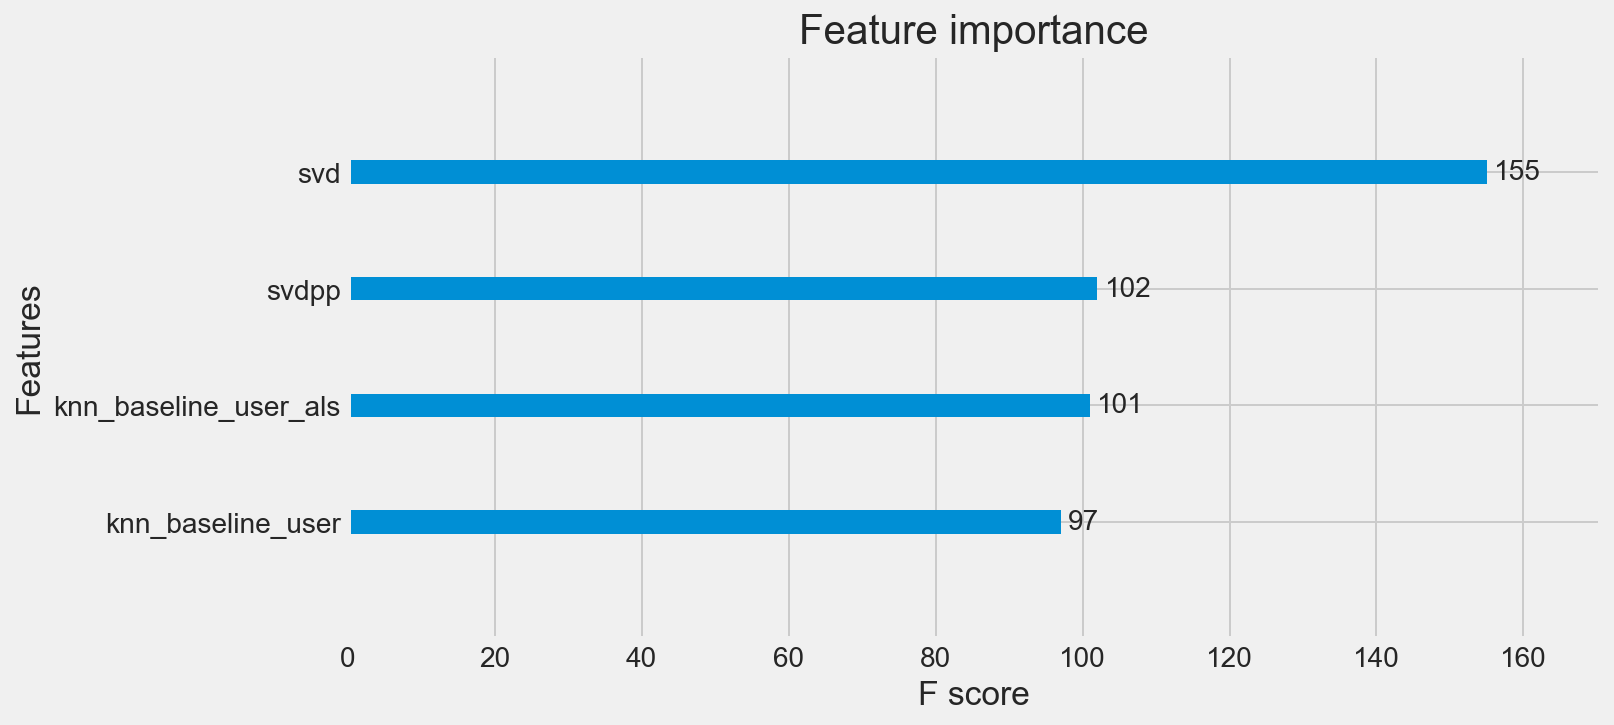

In [59]:
xgb_all_models = xgb.XGBRegressor(n_estimators = 66, max_depth = 3, n_jobs= -1, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_assignment'] = train_results
models_evaluation_test['xgb_assignment'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

<h1>Summary(with only the created features)</h1>
<p>Here is a Comparison of our models.</p>


<table style="width:100%">
  <tr>
    <th>SVD</th>
    <th>SVD++</th>
    <th>KNN baseline als</th>
     <th>KNN Baseline user</th>
      
      
      
  </tr>
  <tr>
    <td>155</td>
    <td>102</td>
    <td>101</td>
    <td>107</td>
   
  </tr>
   
</table> 